This file contains our functions for:
- Column renaming
- Median Imputation for null values
- Outlier removal
- Feature Selction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import data_processing as dp
import warnings

warnings.filterwarnings("ignore")

data = arff.loadarff("../data/3year.arff")
df = pd.DataFrame(data[0])
df_origin = df.copy()
df.head()

ModuleNotFoundError: No module named 'python_scripts'

Rename Columns

In [2]:
# rename columns
names = [
    "net profit / total assets",
    "total liabilities / total assets",
    "working capital / total assets",
    "current assets / short-term liabilities",
    "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
    "retained earnings / total assets",
    "EBIT / total assets",
    "book value of equity / total liabilities",
    "sales / total assets",
    "equity / total assets",
    "(gross profit + extraordinary items + financial expenses) / total assets",
    "gross profit / short-term liabilities",
    "(gross profit + depreciation) / sales",
    "(gross profit + interest) / total assets",
    "(total liabilities * 365) / (gross profit + depreciation)",
    "(gross profit + depreciation) / total liabilities",
    "total assets / total liabilities",
    "gross profit / total assets",
    "gross profit / sales",
    "(inventory * 365) / sales",
    "sales (n) / sales (n-1)",
    "profit on operating activities / total assets",
    "net profit / sales",
    "gross profit (in 3 years) / total assets",
    "(equity - share capital) / total assets",
    "(net profit + depreciation) / total liabilities",
    "profit on operating activities / financial expenses",
    "working capital / fixed assets",
    "logarithm of total assets",
    "(total liabilities - cash) / sales",
    "(gross profit + interest) / sales",
    "(current liabilities * 365) / cost of products sold",
    "operating expenses / short-term liabilities",
    "operating expenses / total liabilities",
    "profit on sales / total assets",
    "total sales / total assets",
    "(current assets - inventories) / long-term liabilities",
    "constant capital / total assets",
    "profit on sales / sales",
    "(current assets - inventory - receivables) / short-term liabilities",
    "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
    "profit on operating activities / sales",
    "rotation receivables + inventory turnover in days",
    "(receivables * 365) / sales",
    "net profit / inventory",
    "(current assets - inventory) / short-term liabilities",
    "(inventory * 365) / cost of products sold",
    "EBITDA (profit on operating activities - depreciation) / total assets",
    "EBITDA (profit on operating activities - depreciation) / sales",
    "current assets / total liabilities",
    "short-term liabilities / total assets",
    "(short-term liabilities * 365) / cost of products sold)",
    "equity / fixed assets",
    "constant capital / fixed assets",
    "working capital",
    "(sales - cost of products sold) / sales",
    "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
    "total costs /total sales",
    "long-term liabilities / equity",
    "sales / inventory",
    "sales / receivables",
    "(short-term liabilities *365) / sales",
    "sales / short-term liabilities",
    "sales / fixed assets",
    "class",
]

y = df["class"]
df.columns = names

NameError: name 'df' is not defined

Convert target column to discrete classes

In [3]:
def as_discrete(col):
    n = len(col)
    new_col = [0] * n
    for i in range(n):
        if col[i] == b"0":
            new_col[i] = 0
        else:
            new_col[i] = 1
    return pd.DataFrame(new_col)


def get_Xy(df):
    X = df_origin.iloc[:, 0 : len(df.columns) - 1]
    y = as_discrete(df.iloc[:, -1])
    return X, y

In [4]:
X, y = get_Xy(df)

### Handle Missing Values

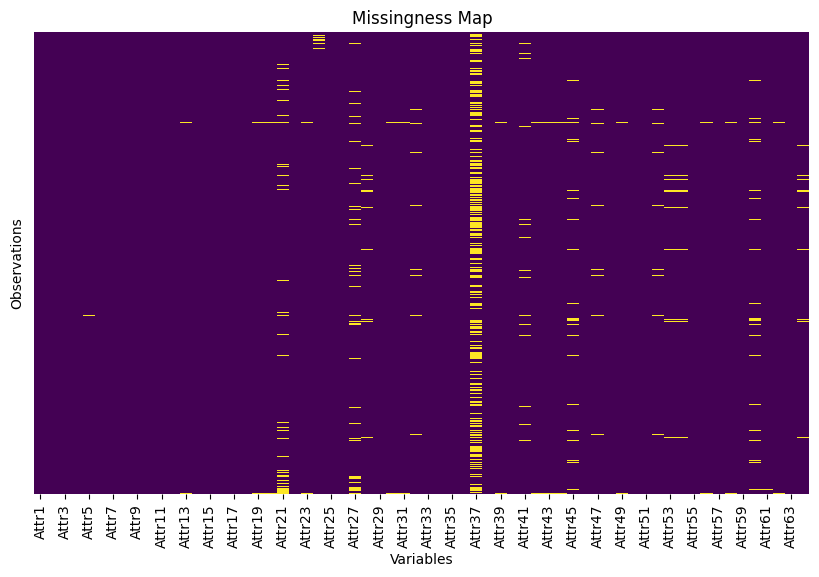

In [5]:
# Create a missingness matrix
missing_values = X.isnull()

# Plot the missingness map
plt.figure(figsize=(10, 6))
sns.heatmap(missing_values, cmap="viridis", cbar=False)
plt.title("Missingness Map")
plt.xlabel("Variables")
plt.ylabel("Observations")
plt.yticks([])
plt.show()

In [6]:
# Find the number of null values in each column
null_counts = X.isnull().sum()
print("Number of null values in each column:")
print(null_counts)

# Calculate the threshold for more than 40% of the entries to be null
threshold = X.shape[0] * 0.4

# Use boolean indexing to filter columns where the number of null values exceeds the threshold
columns_with_many_nulls = X.columns[X.isnull().sum() > threshold]

print("Columns where more than 40% of the entries are null:")
print(columns_with_many_nulls)

Number of null values in each column:
Attr1       0
Attr2       0
Attr3       0
Attr4      18
Attr5      25
         ... 
Attr60    592
Attr61     17
Attr62     43
Attr63     18
Attr64    228
Length: 64, dtype: int64
Columns where more than 40% of the entries are null:
Index(['Attr37'], dtype='object')


From the above result, we found that column `Attr37` which corresponds to `(current assets - inventories) / long-term liabilities` has more than 40% of the entries being null. Keeping this column can introduce noise and unnecessary complexity without adding meaningful insights. Therefore we decide to drop the it from our predictor variables. 

In [7]:
# function for null removal
def med_impute(df, y):

    # remove columns with more than 40% values being null
    thd1 = df.shape[0] * 0.4
    cols = df.columns[df.isnull().sum() < thd1]
    df = df[cols]

    # remove rows with more than 50% values being null
    thd2 = df.shape[1] * 0.5
    y = y[df.isnull().sum(axis=1) <= thd2]
    df = df[df.isnull().sum(axis=1) <= thd2]

    # median imputation for null values
    df.fillna(df.median())

    return df, y

In [8]:
X_imputed, y = med_impute(X, y)

### Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(df)
X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

# without changing column names
x_scaled_origin = scaler.fit_transform(X_imputed)
X_scaled_df_origin = pd.DataFrame(x_scaled_origin, columns=X_imputed.columns)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

### Removing highly correlated features
Features that are strongly correlated to each other, bring little new information to a dataset but add to the complexity. Thus in the following section, we will be plotting a heatmap to visualise the correlation between each pair of predictors and filter out strongly correlated pairs using 0.7 as our threshold. We will then proceed to drop one from each pair. 

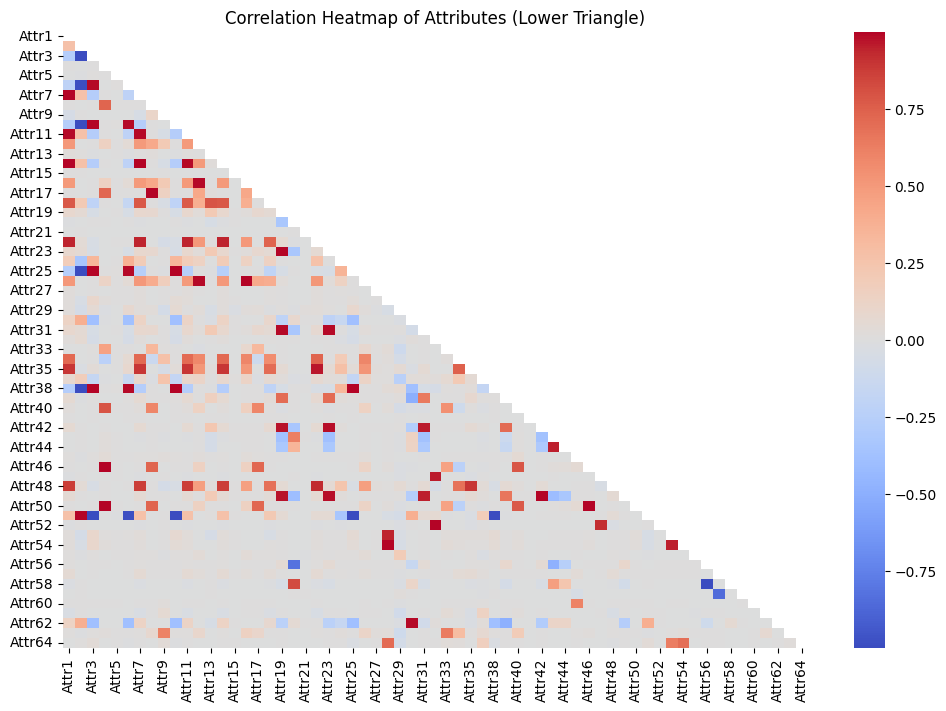

In [10]:
# Calculate the correlation matrix
corr_matrix = X_scaled_df_origin.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap with the mask applied
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", mask=mask)
plt.title("Correlation Heatmap of Attributes (Lower Triangle)")
plt.show()

<AxesSubplot: >

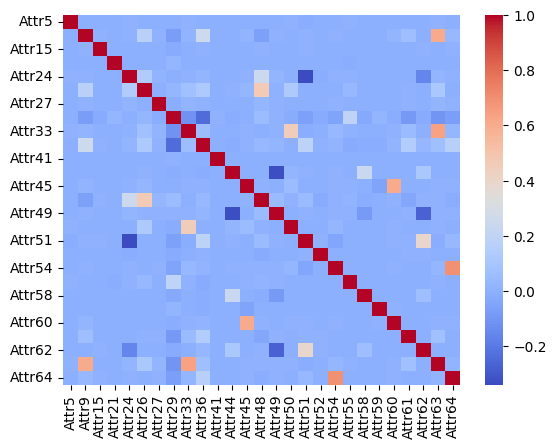

In [11]:
# Set the correlation threshold
threshold = 0.7

# Calculate the correlation matrix
correlation_matrix = X_scaled_df_origin.corr()

attr_list = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            if correlation_matrix.columns[j] not in attr_list:
                attr_list.append(correlation_matrix.columns[j])

X_scaled_df_origin_low_cor = X_scaled_df_origin.drop(columns=attr_list)

sns.heatmap(X_scaled_df_origin_low_cor.corr(), annot=False, cmap="coolwarm")

In [12]:
# find pairs with high correlation
high_cor = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            if correlation_matrix.columns[j] != correlation_matrix.columns[i]:
                high_cor.append(
                    [
                        correlation_matrix.columns[i],
                        correlation_matrix.columns[j],
                        correlation_matrix.iloc[i, j],
                    ]
                )

# print(high_cor[:5])
# len(high_cor)

pos_high_cor = []
neg_high_cor = []
for i in range(len(high_cor)):
    if high_cor[i][2] > 0:
        pos_high_cor.append(high_cor[i])
    else:
        neg_high_cor.append(high_cor[i])

print(len((pos_high_cor)))
print(pos_high_cor[:5])

83
[['Attr6', 'Attr3', 0.9847690510248809], ['Attr7', 'Attr1', 0.9986695819981257], ['Attr8', 'Attr4', 0.7299698075614232], ['Attr10', 'Attr3', 0.9979247141496432], ['Attr10', 'Attr6', 0.9860108259523822]]


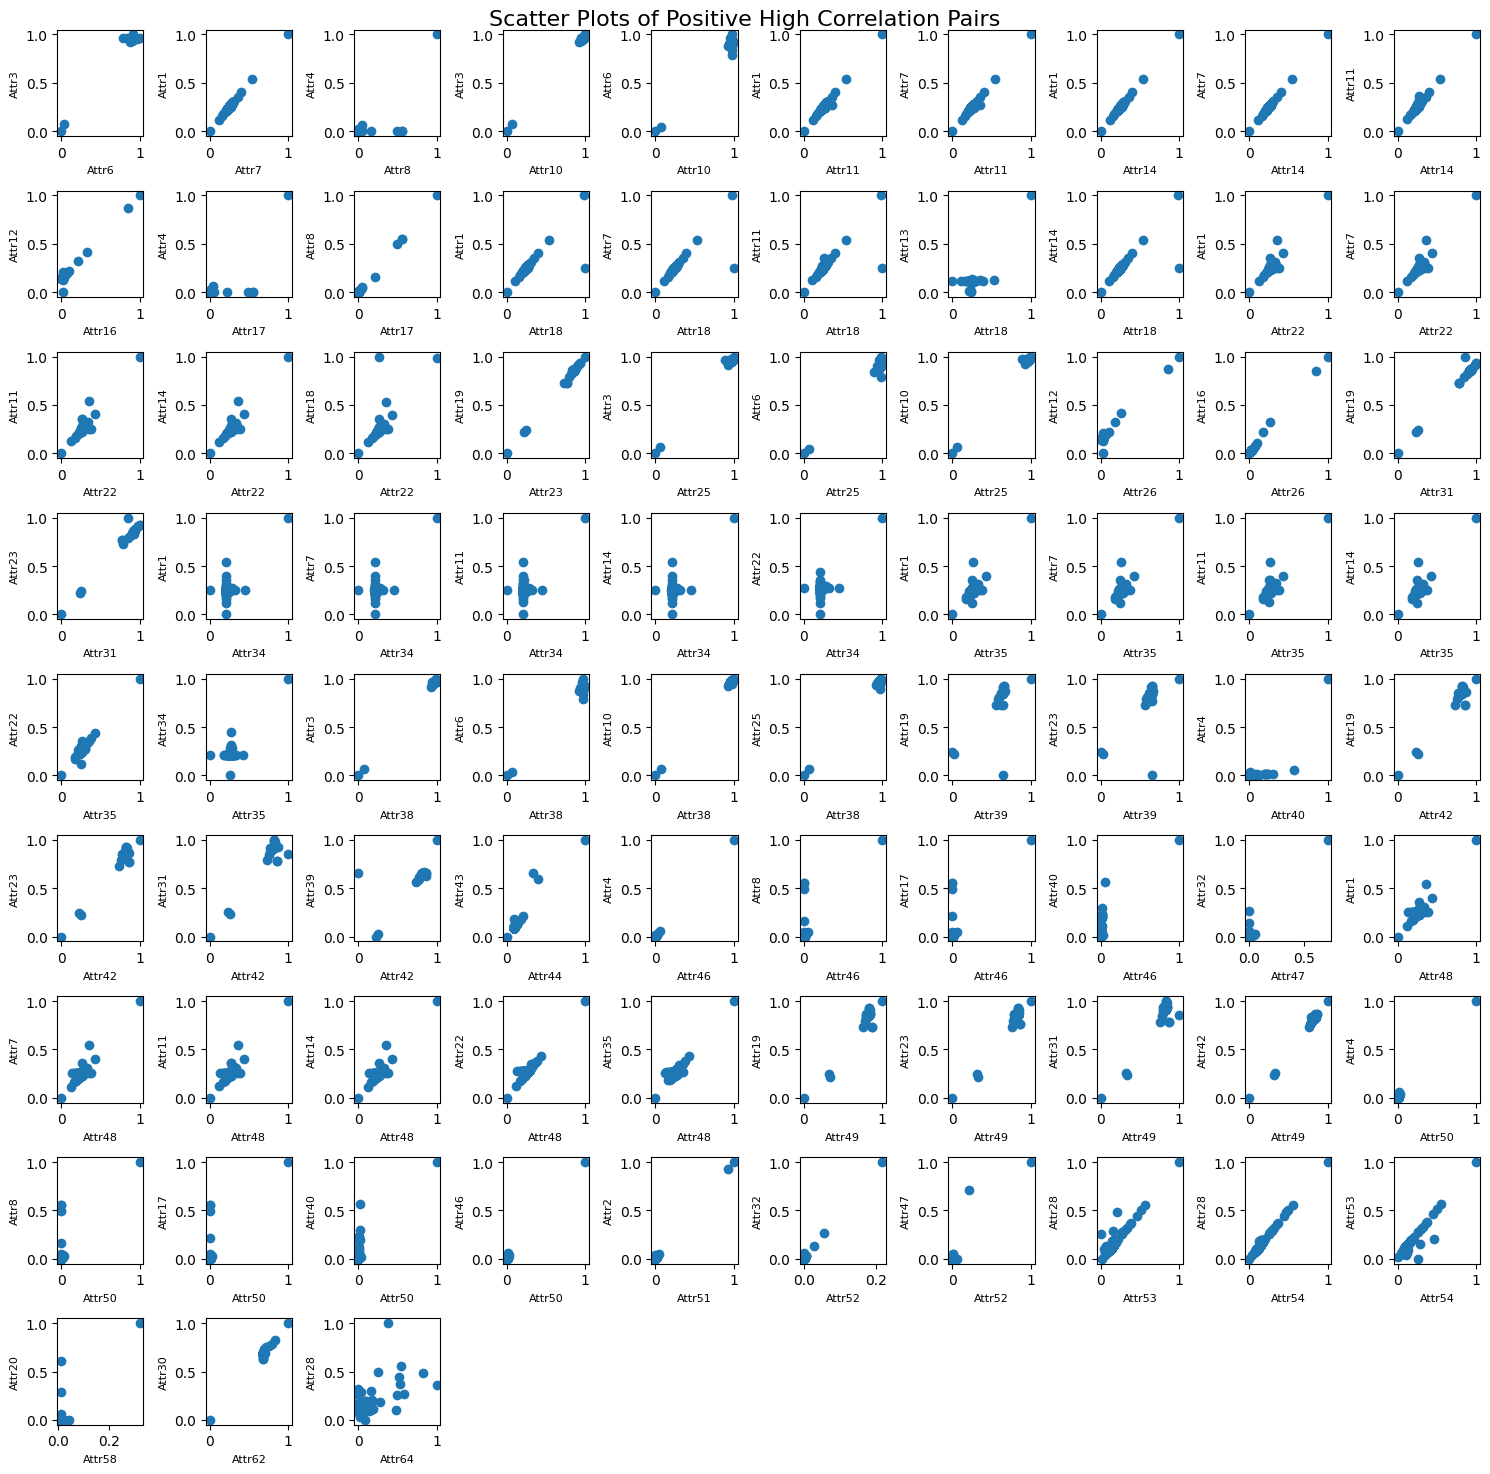

In [13]:
# Define the number of rows and columns for subplots
num_rows = 9  # Adjust this based on the number of pairs you have
num_cols = 10

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot each pair of attributes with high correlation
for i, pair in enumerate(pos_high_cor):
    ax = axes[i]
    ax.scatter(X_scaled_df_origin[pair[0]], X_scaled_df_origin[pair[1]])
    ax.set_xlabel(pair[0], fontsize=8)
    ax.set_ylabel(pair[1], fontsize=8)
    # ax.set_title('High Correlation Pair')

# Remove any unused subplots
for i in range(len(pos_high_cor), num_rows * num_cols):
    fig.delaxes(axes[i])
fig.suptitle("Scatter Plots of Positive High Correlation Pairs", fontsize=16)
plt.tight_layout()
plt.show()

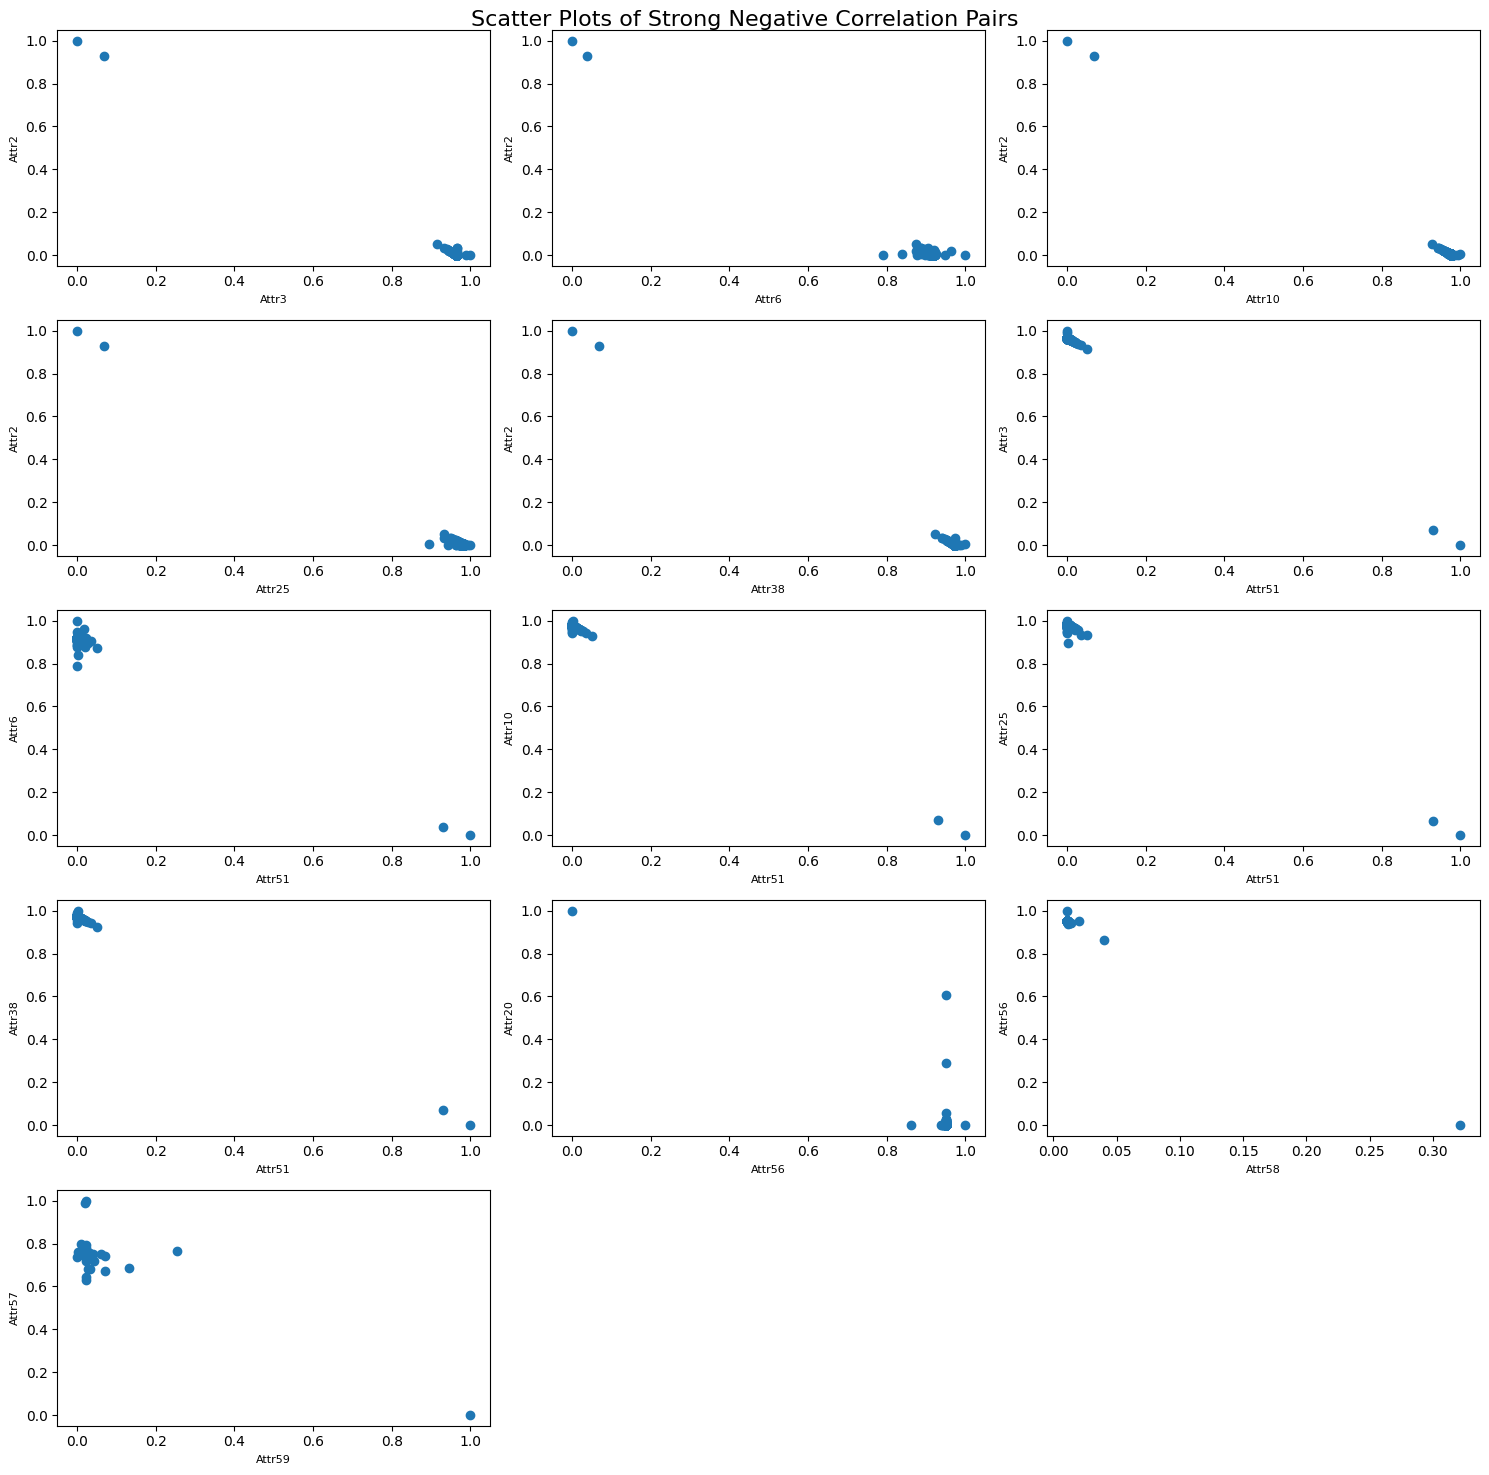

In [14]:
# import matplotlib.pyplot as plt

# Define the number of rows and columns for subplots
num_rows = 5  # Adjust this based on the number of pairs you have
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot each pair of attributes with high correlation
for i, pair in enumerate(neg_high_cor):
    ax = axes[i]
    ax.scatter(X_scaled_df_origin[pair[0]], X_scaled_df_origin[pair[1]])
    ax.set_xlabel(pair[0], fontsize=8)
    ax.set_ylabel(pair[1], fontsize=8)
    # ax.set_title('High Correlation Pair')

# Remove any unused subplots
for i in range(len(neg_high_cor), num_rows * num_cols):
    fig.delaxes(axes[i])

fig.suptitle("Scatter Plots of Strong Negative Correlation Pairs", fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Create a set to keep track of already dropped variables
dropped_features = []
X_scaled_df_origin_drop = X_scaled_df_origin.copy()

# Iterate through the list of highly correlated pairs
for pair in high_cor:
    feature1, feature2, correlation = pair

    # Check if either of the features in the pair has already been dropped
    if feature1 not in dropped_features and feature2 not in dropped_features:
        # Check if the feature exists in the DataFrame before attempting to drop it
        if feature2 in X_scaled_df_origin.columns:
            # Drop one of the correlated features from the dataset
            # Here, we arbitrarily choose to drop the second feature in the pair
            X_scaled_df_origin_drop.drop(feature2, axis=1, inplace=True)
            dropped_features.append(feature2)
        else:
            print(f"Feature '{feature2}' not found in the DataFrame.")

print(X_scaled_df_origin_drop.shape)
print(len(dropped_features))

(10501, 27)
36


### Feature selection

ANOVA F-measure
- Features selection for numerical inputs and categorical output  
- Hypothesis:
    -  H0: Means of all groups are equal.   
    -  H1: At least one mean of the groups are different.

In [16]:
X_smote, X_test, y_smote, y_test = dp.pre_process(df)
print(X_smote.shape)
print(y_smote.shape)
print(y_smote.value_counts())  # balanced class

(13978, 30)
(13978, 1)
0    6989
1    6989
Name: count, dtype: int64


Shape of df after ANOVA f-test feature selection: (13978, 30)


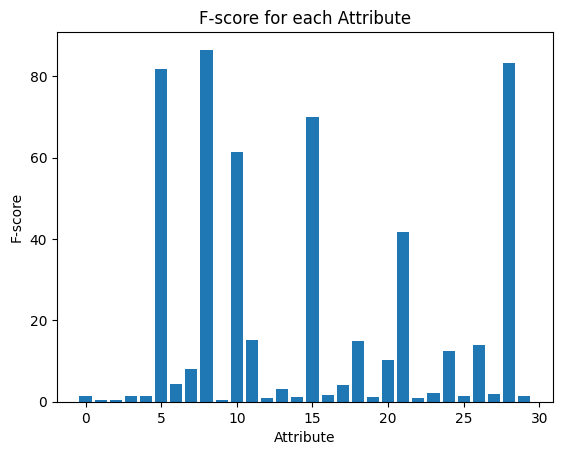

In [17]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest, f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k="all")

# apply feature selection
X_selected = fs.fit_transform(X_smote, y_smote)
print(f"Shape of df after ANOVA f-test feature selection: {X_selected.shape}")

# what are scores for the features - larger score the better
# for i in range(len(fs.scores_)):
#  print("Feature %d: %f" % (i, fs.scores_[i]))

# plot the scores
fig, ax = plt.subplots()
ax.bar([i for i in range(len(fs.scores_))], fs.scores_)
ax.set(title="F-score for each Attribute", ylabel="F-score", xlabel="Attribute")
plt.show()

In [18]:
def get_df_with_top_k_features(k_features, *args):
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # define feature selection
    fs = SelectKBest(score_func=f_classif, k=k_features)

    # apply feature selection
    fs.fit_transform(X_train, y_train)

    # Take the features with the highest F-scores
    fs_scores_array = np.array(fs.scores_)

    # Get the indices that would sort the array in descending order
    sorted_indices_desc = np.argsort(fs_scores_array)[::-1]

    # Take the top k indices
    top_indices = sorted_indices_desc[:k_features]

    selected_columns_X_train = X_train.iloc[:, top_indices]
    selected_columns_X_test = X_test.iloc[:, top_indices]

    return selected_columns_X_train, selected_columns_X_test, y_train, y_test


k_features = 25
X_smote1, X_test1, y_smote1, y_test1 = get_df_with_top_k_features(
    k_features, X_smote, X_test, y_smote, y_test
)
print(X_smote.shape)  # (13978, 25)

(13978, 30)
